In [1]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt


import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.stats import binned_statistic

import seaborn as sns

import statsmodels.api as sm

from scipy import stats

In [5]:
dwarf_table = Table.read('new_dwarf_table.txt', format = 'ascii.commented_header')
dwarf_table[20:40]

aimc,IN_DR7_LSS,RA,DEC,Z,ELPETRO_ABSMAG_r,u_r,sSFR,HImass,flag3727,t3,Z12logOH,Zerr,logNO,NOerr,vflag_VF,ID#,BPTclass,ELPETRO_MASS,ID,N2O2,N2,O3N2,log_M_sSFR,change_log_sSFR,Z12logOH_N2,Z12logOH_O3N2,Z12logOH_N2O2,2D_neighbor_ID,2D_neighbor_dist,2D_neighbor_ID_vir,2D_neighbor_dist_vir,3D_neighbor_ID,3D_neighbor_dist,3D_neighbor_ID_vir,3D_neighbor_dist_vir
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,int32,float64,int32,float64,int32,float64
-99.0,1.0,154.65694596052526,-0.42196279812925064,0.01811487227678299,-16.288087844848633,0.9270355105400085,nan,nan,nan,nan,nan,nan,nan,nan,1,1829,nan,163911600.0,1829,2.827166949830466e-06,0.10052702545186877,0.45810694889501546,192.28369140625,nan,nan,nan,nan,586495,0.21727490773680622,586495,4.047816827440823,586495,0.22228721535002324,586495,4.141195779075985
172.62,1.0,153.75970620721034,0.9682556489167827,0.021199265494942665,-16.96735191345215,1.2557484209537506,-9.458992958068848,nan,0.0,2.7247581213022816,7.30349211034837,0.3358532639275543,-0.9601565188559871,0.46385247409254277,2,1943,1.0,245185872.0,1943,--,0.16902087245812544,0.03461347589779065,230.4873046875,-228.24033876273813,51.45457918663104,51.139584879990494,--,61008,0.39972370540896796,61008,2.236739518477444,60757,1.1036625638046138,60997,5.287124858231159
0.0,1.0,155.41179798948707,0.9002553533325333,0.0023375554010272026,-12.911161422729492,1.4624316990375519,-8.750261306762695,7.41,nan,nan,nan,nan,nan,nan,2,2092,2.0,3599119.25,2092,--,--,--,12.939453125,-10.770369561446364,--,--,--,608190,0.3759800772713868,587104,4.815857271681121,609324,0.5525273695267658,587447,7.597122510807735
144.23,1.0,155.9828028458709,1.033402258131225,0.02267528884112835,-16.907424926757812,1.3205188512802124,-9.122611045837402,9.26,0.0,1.545316433107025,7.815227912034597,0.13961481456371194,-1.332553203579339,0.17404300822811938,2,2309,1.0,129763728.0,2309,--,0.05174058705336544,0.07989971835891811,172.32080078125,-170.11004471925378,39.723231098137774,40.408442593829136,--,2336,0.2123494973962944,2336,0.7181639927834441,2333,0.4785615808127944,2333,3.8785740594358127
48.24,1.0,156.0591174756552,0.14773846624918113,0.023326674476265907,-16.590179443359375,1.5584875643253326,-10.03125,nan,nan,nan,nan,nan,nan,nan,2,2361,1.0,341758016.0,2361,--,0.19077787271542365,0.0791867691749299,265.865234375,-263.5595291546697,58.2354561506712,57.2322179838371,--,586725,0.03398273570332749,586725,0.14926278717424318,586725,0.26072261428417004,586725,1.145175139139837
128.66,1.0,159.30951877078462,-0.08743954419338047,0.021261854097247124,-16.6418399810791,1.7035429179668427,-9.632553100585938,nan,nan,nan,nan,nan,nan,nan,2,2457,1.0,301768544.0,2457,6.252610894214924e-05,0.12031638868195854,0.018992519561917963,252.18115234375,-249.9160040335986,55.37581511494795,55.23326795312174,93.94260122559145,587198,0.21474116954670946,587198,3.5350305558999526,587108,0.838293159661571,587267,9.52980778658316
144.71,1.0,158.93195067864386,0.00855941231520523,0.01676873490214348,-16.140260696411133,1.316695660352707,-9.58098030090332,nan,nan,nan,nan,nan,nan,nan,1,2728,1.0,144922480.0,2728,-0.0023858028783293253,0.08446804421145912,0.08262795325516943,181.56787109375,-179.3080911791419,41.75513576916559,42.053346728588764,--,2474,0.3550145741418967,2474,2.668094728546813,2474,0.40352895863164473,2474,3.032702220587558
126.68,1.0,159.00858821437066,0.9890581756152056,0.018943272531032562,-16.428030014038086,1.3676829636096954,-9.606098175048828,nan,nan,nan,nan,nan,nan,nan,1,2734,1.0,251180672.0,2734,--,0.12417742420675403,0.023671731478815936,232.93994140625,-230.6775432828796,51.73882776425462,51.69986937727283,--,587180,0.5874650760881942,2910,3.2499559923477532,587188,0.9829707888542664,2910,3.646374962880311
82.17,1.0,161.18210833928825,-0.19504801394669183,0.014977285638451576,-

In [6]:
# if still want to do the t3 limit

t3mask = dwarf_table['t3'] < 3  # Makes a boolean selection mask (numpy array)
dwarf_t3= dwarf_table[t3mask]

In [7]:
# Separating into Void, Wall, or Other Dwarf Galaxies

dwarf_wall = dwarf_table['vflag_VF']==0
dwarf_void = dwarf_table['vflag_VF']==1
dwarf_other = ~(dwarf_wall | dwarf_void)


dwarf_wall_t3 = dwarf_t3['vflag_VF']==0
dwarf_void_t3 = dwarf_t3['vflag_VF']==1
dwarf_other_t3 = ~(dwarf_wall_t3 | dwarf_void_t3)

In [10]:
# only star forming dwarfs
sfd = dwarf_table['BPTclass'] == 1
sfd_t3 = dwarf_t3['BPTclass'] == 1

In [8]:
def profilehist(x, y, w=None, bins=10, uncertainty='stderr'):
    """Compute a profile histogram given x, y and optional weights.
    
    Parameters
    ----------
    x : (N,) array_like
        Sequence of values to be binned.
    y : (N,) array_like
        Data on which the statistic will be computed.
    w : None or (N,) array_like
        Weights for each data point y.
    bins : int or array_like
        If int, define equal-length bins given by data min/max range; else, user-defined bin edges.
    uncertainty : str
        'stderr' to compute standard error on the mean; 'sample' for sample uncertainty
        
    Returns
    -------
    xc : array of dtype float
        Bin centers in x.
    yavg : array of dtype float
        Average in each bin.
    yerr : array of dtype float
        Uncertainty in each bin (sample error or error on the mean).
    """
    # Default to equal weights in each bin.
    if w is None:
        w = np.ones_like(y, dtype=np.float64)

    # Compute weighted sums and construct the weighted means and uncertainties.
    (Y, E, W), edges, idx = binned_statistic(x, [w*y, w*y**2, w], bins=bins, statistic='sum')
    yavg = Y/W
    ystd = np.sqrt(E/W - yavg**2)
    yerr = ystd/np.sqrt(W)

    # Compute bin centers.
    xc = 0.5*(edges[1:] + edges[:-1])
    
    if uncertainty == 'sample':
        return xc, yavg, ystd
    elif uncertainty == 'stderr':
        return xc, yavg, yerr
    else:
        raise ValueError(f'uncertainty={uncertainty} unknown; allowed: "stderr" and "sample"')

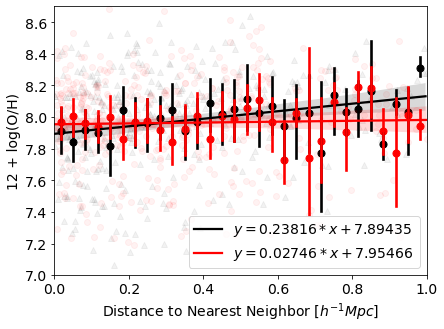

In [11]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
d_max = 1
for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    d_all = dwarf_t3['2D_neighbor_dist'][select & sfd_t3]
    vals_all = dwarf_t3['Z12logOH'][select & sfd_t3]
    
    #d_all = dwarf_t3['2D_neighbor_dist'][select]
    #vals_all = dwarf_t3['Z12logOH'][select]
    
    mask = (d_all > 0) & (d_all <= 1)
    d = d_all[mask]
    vals = vals_all[mask]
    
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
        
    xedges = np.linspace(0,1,31)
    xcenters = 0.5*(xedges[1:] + xedges[:-1])
        
    #sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
        
    slope, intercept, r_value, pv, se = stats.linregress(d[nonan], vals[nonan])
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, 
                line_kws={'label':'$y=%3.7s*x+%3.7s$'%(slope, intercept)})      
        
    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='12 + log(O/H)', xlim=(0,1), ylim=(7,8.7));
        
    ax.legend()
        
    #fig.savefig('sfd_Z12logOH_2D_LR.png')

C:\Users\caeho\anaconda3\lib\site-packages\numpy\lib\function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\caeho\anaconda3\lib\site-packages\numpy\lib\function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\caeho\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\caeho\anaconda3\lib\site-packages\numpy\lib\function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\caeho\anaconda3\lib\site-packages\numpy\lib\function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\caeho\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


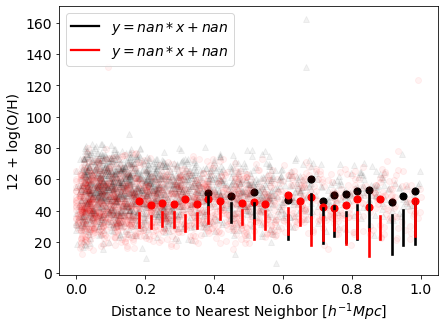

In [21]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
d_max = 1
for select, mc, label, c, m in zip([dwarf_wall, dwarf_void], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    #d_all = dwarf_table['2D_neighbor_dist'][select & sfd]
    #vals_all = dwarf_table['Z12logOH_N2'][select & sfd]
    
    d_all = dwarf_table['2D_neighbor_dist'][select]
    vals_all = dwarf_table['Z12logOH_N2'][select]
    
    mask = (d_all > 0) & (d_all <= 1)
    d = d_all[mask]
    vals = vals_all[mask]
    
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
        
    xedges = np.linspace(0,1,31)
    xcenters = 0.5*(xedges[1:] + xedges[:-1])
        
    #sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
        
    slope, intercept, r_value, pv, se = stats.linregress(d[nonan], vals[nonan])
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, 
                line_kws={'label':'$y=%3.7s*x+%3.7s$'%(slope, intercept)})      
        
    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='12 + log(O/H)')#, xlim=(0,1), ylim=(7,8.7));
        
    ax.legend()
        
    #fig.savefig('sfd_Z12logOH_2D_LR.png')

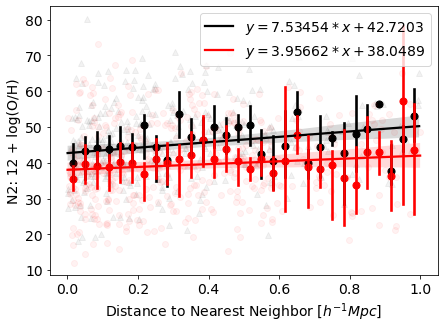

In [13]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
d_max = 1
for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    #d_all = dwarf_t3['2D_neighbor_dist'][select & sfd_t3]
    #vals_all = dwarf_t3['Z12logOH_N2'][select & sfd_t3]
    
    d_all = dwarf_t3['2D_neighbor_dist'][select]
    vals_all = dwarf_t3['Z12logOH_N2'][select]
    
    mask = (d_all > 0) & (d_all <= 1)
    d = d_all[mask]
    vals = vals_all[mask]
    
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
        
    xedges = np.linspace(0,1,31)
    xcenters = 0.5*(xedges[1:] + xedges[:-1])
        
    #sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
        
    slope, intercept, r_value, pv, se = stats.linregress(d[nonan], vals[nonan])
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, 
                line_kws={'label':'$y=%3.7s*x+%3.7s$'%(slope, intercept)})      
        
    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='N2: 12 + log(O/H)')#, xlim=(0,1), ylim=(7,8.7));
        
    ax.legend()

C:\Users\caeho\anaconda3\lib\site-packages\numpy\ma\core.py:2829: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
C:\Users\caeho\anaconda3\lib\site-packages\numpy\ma\core.py:2829: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


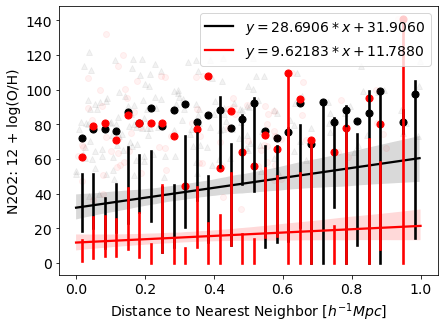

In [14]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
d_max = 1
for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    #d_all = dwarf_t3['2D_neighbor_dist'][select & sfd_t3]
    #vals_all = dwarf_t3['Z12logOH_N2O2'][select & sfd_t3]
    
    d_all = dwarf_t3['2D_neighbor_dist'][select]
    vals_all = dwarf_t3['Z12logOH_N2O2'][select]
    
    mask = (d_all > 0) & (d_all <= 1)
    d = d_all[mask]
    vals = vals_all[mask]
    
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
        
    xedges = np.linspace(0,1,31)
    xcenters = 0.5*(xedges[1:] + xedges[:-1])
        
    #sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
        
    slope, intercept, r_value, pv, se = stats.linregress(d[nonan], vals[nonan])
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, 
                line_kws={'label':'$y=%3.7s*x+%3.7s$'%(slope, intercept)})      
        
    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='N2O2: 12 + log(O/H)')#, xlim=(0,1), ylim=(7,8.7));
        
    ax.legend()

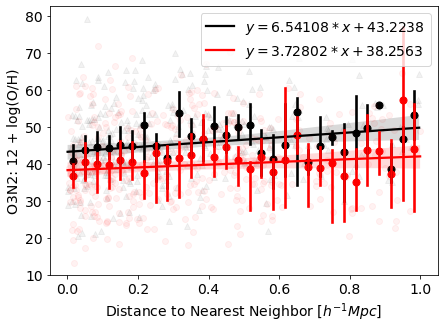

In [15]:
fig, ax = plt.subplots(1,1, figsize=(6.4,4.8), tight_layout=True)
plt.rcParams.update({'font.size': 14})
d_max = 1
for select, mc, label, c, m in zip([dwarf_wall_t3, dwarf_void_t3], ['black', 'red'], ['wall', 'void'], ['k', 'r'], ['^', 'o']):
    
    #d_all = dwarf_t3['2D_neighbor_dist'][select & sfd_t3]
    #vals_all = dwarf_t3['Z12logOH_O3N2'][select & sfd_t3]
    
    d_all = dwarf_t3['2D_neighbor_dist'][select]
    vals_all = dwarf_t3['Z12logOH_O3N2'][select]
    
    mask = (d_all > 0) & (d_all <= 1)
    d = d_all[mask]
    vals = vals_all[mask]
    
    nonan = ~np.isnan(vals)
       
    ax.scatter(d[nonan], vals[nonan], alpha=0.05, color=c, marker=m)
        
    xedges = np.linspace(0,1,31)
    xcenters = 0.5*(xedges[1:] + xedges[:-1])
        
    #sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, label=label)
        
    slope, intercept, r_value, pv, se = stats.linregress(d[nonan], vals[nonan])
    sns.regplot(x=d[nonan], y=vals[nonan], x_bins=xcenters, color=mc, ax=ax, 
                line_kws={'label':'$y=%3.7s*x+%3.7s$'%(slope, intercept)})      
        
    ax.set(xlabel='Distance to Nearest Neighbor [$h^{-1}Mpc]$', ylabel='O3N2: 12 + log(O/H)')#, xlim=(0,1), ylim=(7,8.7));
        
    ax.legend()

In [17]:
len(dwarf_table)
#len(dwarf_t3)

12950